In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
import matplotlib.pyplot as plt
import re
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from matplotlib_venn import venn2



# Phase 1 Comparison

In [2]:
# load the data
root = os.path.dirname(os.getcwd())
data_dir = os.path.join(root, "data")
files = {
    "long": {
        "lymphoma":{
            "train": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" in file or "lymph" in file) and "long_cleaned" in file] if "train" in x),
            "test": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" in file or "lymph" in file) and "long_cleaned" in file] if "test" in x)
        },
        "oncology": {
            "train": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" not in file and "lymph" not in file) and "long_cleaned" in file] if "train" in x),
            "test": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" not in file and "lymph" not in file) and "long_cleaned" in file] if "test" in x)
        }
    },
    "clinicalai":{
        "lymphoma phase1": {
            "train": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" in file or "lymph" in file) and "long_cleaned" not in file and "csv" in file] if "train" in x),
            "test": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" in file or "lymph" in file) and "long_cleaned" not in file and "csv" in file] if "test" in x)
        },
        "oncology phase1": {
            "train": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" not in file and "lymph" not in file) and "long_cleaned" not in file and "cleaned_data_phase1" in file and "csv" in file] if "train" in x),
            "test": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" not in file and "lymph" not in file) and "long_cleaned" not in file and "cleaned_data_phase1" in file and "csv" in file] if "test" in x)
        },
        "oncology phase2": {
            "train": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" not in file and "lymph" not in file) and "long_cleaned" not in file and "cleaned_data_phase2" in file and "csv" in file] if "train" in x),
            "test": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" not in file and "lymph" not in file) and "long_cleaned" not in file and "cleaned_data_phase2" in file and "csv" in file] if "test" in x)
        },
        "oncology phase3": {
            "train": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" not in file and "lymph" not in file) and "long_cleaned" not in file and "cleaned_data_phase3" in file and "csv" in file] if "train" in x),
            "test": next(x for x in [file for file in os.listdir(data_dir) if ("lungc" not in file and "lymph" not in file) and "long_cleaned" not in file and "cleaned_data_phase3" in file and "csv" in file] if "test" in x)
        }

    }
}

files

{'long': {'lymphoma': {'train': 'long_cleaned_data_phase1_lymph_2bin_train.csv',
   'test': 'long_cleaned_data_phase1_lungc_2bin_test.csv'},
  'oncology': {'train': 'long_cleaned_data_phase1_oncol_2bin_train.csv',
   'test': 'long_cleaned_data_phase1_oncol_2bin_test.csv'}},
 'clinicalai': {'lymphoma phase1': {'train': 'cleaned_data_phase1_lymph_2bin_train.csv',
   'test': 'cleaned_data_phase1_lungc_2bin_test.csv'},
  'oncology phase1': {'train': 'cleaned_data_phase1_2bin_train.csv',
   'test': 'cleaned_data_phase1_2bin_test.csv'},
  'oncology phase2': {'train': 'cleaned_data_phase2_2bin_train.csv',
   'test': 'cleaned_data_phase2_2bin_test.csv'},
  'oncology phase3': {'train': 'cleaned_data_phase3_2bin_train.csv',
   'test': 'cleaned_data_phase3_2bin_test.csv'}}}

In [3]:
def train_and_retrain_model(model_type, data, train_data, drop_cols, root, model_class):
    # file = [file for file in train_data[model_type][data] if "train" in file]
    file = train_data[model_type][data]["train"]
    df = pd.read_csv(os.path.join(root, "data", file))

    y_cols = ["study_eq_labels"]

    print(df['study_eq_labels'].unique())

    X = df.drop(columns=y_cols+drop_cols)
    features = X.columns
    y = df[y_cols]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scoring = {
        'accuracy': 'accuracy',  # Built-in scoring for accuracy
        'precision': 'precision',  # Built-in scoring for precision
        'recall': 'recall',  # Built-in scoring for recall
        'f1': 'f1',  # Built-in scoring for F1-score
        'roc_auc': 'roc_auc',  # Built-in scoring for AUC-ROC
    }


    if model_class == 'rf':
        model = RandomForestClassifier(random_state=42)

        param_grid = {
        'n_estimators': [100, 200, 300],      # Number of trees in the forest
        'max_depth': [None, 10, 20, 30],      # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4],        # Minimum number of samples required to be at a leaf node
        'max_features': ['auto', 'sqrt']      # Number of features to consider at each split
        }
    elif model_class == 'xgb':
        model = xgb.XGBClassifier()

        param_grid = {
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5, 7],
            'min_child_weight': [1, 3, 5],
            'gamma': [0, 0.1, 0.2],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'n_estimators': [50, 100, 200]
        }
    elif model_class == 'lgb':
        model = lgb.LGBMClassifier(random_state=42)

        param_grid = {
            'num_leaves': [20, 30, 40],
            'learning_rate': [0.05, 0.1],
            'n_estimators': [50, 100, 200]
        }

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring=scoring, refit='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    # Predict probabilities for each class
    y_pred_prob = best_model.predict_proba(X_test)

    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_prob, axis=1) + 1

    # Evaluate the model
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc_roc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

    # mae = mean_absolute_error(y_test, y_pred)
    cv_results = cross_validate(
        best_model,
        X,
        y,
        cv=kfold,
        scoring=scoring,
        return_train_score=False,  # Optionally include train scores
    )

    # get the phase
    pattern = r"(phase\d+)"
    match = re.search(pattern, file)

    # data
    data = {
        "data": file,
        "phase": match.group(1) if match else np.nan,
        "key": f"{model_type}_{data}_{model_class}",
        "model": model_class,
        "accuracy": acc,
        "precision": pre,
        "recall": recall,
        "f1": f1,
        "auc roc": auc_roc,
        **{metric: f"{scores.mean():.4f} ± {scores.std():.4f}" 
            for metric, scores in cv_results.items() if "test" in metric}
    }

    data_df = pd.DataFrame([data])
    display(data_df)

    return best_model, data_df, features

In [4]:
def eval_model(model_type, data, train_data, drop_cols, root):
    file = train_data[model_type][data]["test"]
    model = train_data[model_type][data]["model"]
    df = pd.read_csv(os.path.join(root, "data", file))

    y_cols = ["study_eq_labels"]

    X = df.drop(columns=y_cols+drop_cols)
    y = df[y_cols]

    # print(df["study_eq_labels"].unique())
    
    if isinstance(model, list):
        dfs = []
        for i in model:
            for j in i:
                y_pred = i[j].predict(X)
                acc = accuracy_score(y, y_pred)
                pre = precision_score(y, y_pred, average='weighted')
                recall = recall_score(y, y_pred, average='weighted')
                f1 = f1_score(y, y_pred, average='weighted')
                auc_roc = roc_auc_score(y, i[j].predict_proba(X)[:, 1])
                # get the phase
                pattern = r"(phase\d+)"
                match = re.search(pattern, file)

                temp_data = {
                    "data": file,
                    "phase":  match.group(1) if match else np.nan,
                    "model": model_type,
                    "model type": j,
                    "key": f"{model_type}_{data}_{j}",
                    "Accuracy": acc,
                    "Precision": pre,
                    "Recall": recall,
                    "F1 Score": f1,
                    "ROC AUC": auc_roc,
                }
                temp_df = pd.DataFrame(temp_data, index=[0])
                dfs.append(temp_df)
        data_df = pd.concat(dfs)
    display(data_df)

    return data_df

# Train the models

In [5]:
train_results = []

model_classes = ['rf', 'xgb', 'lgb']

features_dict = {"long": {},
                  "clinicalai": {}}


for i in files:
    for j in files[i]:
        saved_models = []
        if i == "long":
            drop_cols = ['study_duration_days', 'study_eq_bins']
            best_model, results, features = train_and_retrain_model(model_type=i, data=j, train_data=files,
                                             drop_cols=drop_cols,
                                             root=root,
                                             model_class='rf')
            files[i][j]["model"] = [{"rf": best_model}]
            features_dict[i][j] = features
            train_results.append(results)
        elif i == "clinicalai":
            for k in model_classes:
                drop_cols = ['protocolSection_identificationModule_nctId',
                            'primary_study_duration_days', 
                            'study_duration_days',
                            'primary_eq_bins',
                            'study_eq_bins',
                            'primary_eq_labels',
                ]
                best_model, results, features = train_and_retrain_model(model_type=i, data=j, train_data=files,
                                        drop_cols=drop_cols,
                                        root=root,
                                        model_class=k)
                train_results.append(results)
                saved_models.append({k: best_model})
            files[i][j]["model"] = saved_models
            features_dict[i][j] = features

train_df = pd.concat(train_results)

[0 1]
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarni

,data,phase,key,model,accuracy,precision,recall,f1,auc roc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,long_cleaned_data_phase1_lymph_2bin_train.csv,phase1,long_lymphoma_rf,rf,0.180095,0.116532,0.180095,0.141503,0.750554,0.6930 ± 0.0198,0.6671 ± 0.0300,0.4931 ± 0.0762,0.5632 ± 0.0534,0.7226 ± 0.0193


[0 1]
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarni

,data,phase,key,model,accuracy,precision,recall,f1,auc roc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,long_cleaned_data_phase1_oncol_2bin_train.csv,phase1,long_oncology_rf,rf,0.186969,0.134212,0.186969,0.156258,0.786561,0.7046 ± 0.0161,0.6978 ± 0.0306,0.6104 ± 0.0160,0.6507 ± 0.0141,0.7731 ± 0.0150


[0 1]
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarni

,data,phase,key,model,accuracy,precision,recall,f1,auc roc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,cleaned_data_phase1_lymph_2bin_train.csv,phase1,clinicalai_lymphoma phase1_rf,rf,0.101064,0.080051,0.101064,0.089338,0.835648,0.7287 ± 0.0130,0.7322 ± 0.0268,0.7095 ± 0.0568,0.7186 ± 0.0221,0.8115 ± 0.0198


[0 1]
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,data,phase,key,model,accuracy,precision,recall,f1,auc roc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,cleaned_data_phase1_lymph_2bin_train.csv,phase1,clinicalai_lymphoma phase1_xgb,xgb,0.106383,0.081833,0.106383,0.092507,0.840972,0.7309 ± 0.0170,0.7312 ± 0.0191,0.7159 ± 0.0566,0.7219 ± 0.0270,0.8258 ± 0.0190


[0 1]
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 305, number of negative: 296
[LightGBM] [Info] Number of positive: 305, number of negative: 297
[LightGBM] [Info] Number of positive: 305, number of negative: 297
[LightGBM] [Info] Number of positive: 305, number of negative: 296
[LightGBM] [Info] Number of positive: 305, number of negative: 297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 305, number of negative: 297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 602, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506645 -> initscore=0.026580
[LightGBM] [Info] Start training from score 0.026580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 305, number of negative: 297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 602, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506645 -> initscore=0.026580
[LightGBM] [Info] Start training from score 0.026580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 305, number of negative: 296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 601, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507488 -> initscore=0.029952
[LightGBM] [Info] Start training from score 0.029952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 601, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507488 -> initscore=0.029952
[LightGBM] [Info] Start training from score 0.029952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 602, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506645 -> initscore=0.026580
[LightGBM] [Info] Start training from score 0.026580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 304, number of negative: 297[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 304, number of negative: 297
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 404
[LightGBM] [Info] Number of data points in the train set: 601, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505824 -> initscore=0.023296
[LightGBM] [Info] Start training from score 0.023296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 304, number of negative: 297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 404
[LightGBM] [Info] Number of data points in the train set: 601, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505824 -> initscore=0.023296
[LightGBM] [Info] Start training from score 0.023296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 305, number of negative: 296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 601, number of used features: 22
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507488 -> initscore=0.029952

[LightGBM] [Info] Start training from score

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 602, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506645 -> initscore=0.026580
[LightGBM] [Info] Start training from score 0.026580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhe

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 305, number of negative: 297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 602, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506645 -> initscore=0.026580
[LightGBM] [Info] Start training from score 0.026580
[LightGBM] [Info] Number of positive: 305, number of negative: 297
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing wa

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 601, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507488 -> initscore=0.029952
[LightGBM] [Info] Start training from score 0.029952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 305, number of negative: 297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cynthiaxu/miniconda3/envs

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 369, number of negative: 383
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 752, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490691 -> initscore=-0.037238
[LightGBM] [Info] Start training from score -0.037238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,data,phase,key,model,accuracy,precision,recall,f1,auc roc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,cleaned_data_phase1_lymph_2bin_train.csv,phase1,clinicalai_lymphoma phase1_lgb,lgb,0.079787,0.06383,0.079787,0.070922,0.836574,0.7447 ± 0.0275,0.7460 ± 0.0202,0.7269 ± 0.0582,0.7353 ± 0.0358,0.8200 ± 0.0242


[1 0]
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarni

,data,phase,key,model,accuracy,precision,recall,f1,auc roc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,cleaned_data_phase1_2bin_train.csv,phase1,clinicalai_oncology phase1_rf,rf,0.141066,0.142392,0.141066,0.141726,0.795572,0.7352 ± 0.0106,0.7324 ± 0.0084,0.7497 ± 0.0174,0.7409 ± 0.0117,0.8159 ± 0.0080


[1 0]
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,data,phase,key,model,accuracy,precision,recall,f1,auc roc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,cleaned_data_phase1_2bin_train.csv,phase1,clinicalai_oncology phase1_xgb,xgb,0.141066,0.138909,0.141066,0.139979,0.795532,0.7352 ± 0.0108,0.7409 ± 0.0082,0.7317 ± 0.0207,0.7361 ± 0.0129,0.8161 ± 0.0110


[1 0]
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] Start training from score 0.022561
[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505392 -> initscore=0.021569
[LightGBM] [I

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [I

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505392 -> initscore=0.021569
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[L

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [I

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505392 -> initscore=0.021569
[LightGBM] [Info] Start training from score 0.021569


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] Start training from score 0.022561


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505392 -> initscore=0.021569
[LightGBM] [Info] Start training from score 0.021569


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] Start training from score 0.022561
[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25[LightGBM] [Info] Total Bins 640

[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.022561
[LightGBM] [I

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505392 -> initscore=0.021569
[LightGBM] [Info] Start training from score 0.021569


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] Start training from score 0.022561


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505392 -> initscore=0.021569
[LightGBM] [Info] Start training from score 0.021569


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.211097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] Start training from score 0.022561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505392 -> initscore=0.021569
[LightGBM] [Info] Start training from score 0.021569
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [bina

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the trai

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] Start training from score 0.022561


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505392 -> initscore=0.021569
[LightGBM] [Info] Start training from score 0.021569
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] Start training from score 0.022561
[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the trai

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] Start training from score 0.022561


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505392 -> initscore=0.021569
[LightGBM] [Info] Start training from score 0.021569
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [I

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599
[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [I

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505392 -> initscore=0.021569
[LightGBM] [Info] Start training from score 0.021569


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1030, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505150 -> initscore=0.020599
[LightGBM] [Info] Start training from score 0.020599


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1031, number of negative: 1008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 640
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505640 -> initscore=0.022561
[LightGBM] [Info] Start training from score 0.022561


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1031, number of negative: 1009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505392 -> initscore=0.021569
[LightGBM] [Info] Start training from score 0.021569


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1288, number of negative: 1261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 2549, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505296 -> initscore=0.021186
[LightGBM] [Info] Start training from score 0.021186


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu

[LightGBM] [Info] Number of positive: 1288, number of negative: 1261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 753
[LightGBM] [Info] Number of data points in the train set: 2549, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505296 -> initscore=0.021186
[LightGBM] [Info] Start training from score 0.021186


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1288, number of negative: 1261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 757
[LightGBM] [Info] Number of data points in the train set: 2549, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505296 -> initscore=0.021186
[LightGBM] [Info] Start training from score 0.021186


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1288, number of negative: 1262
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 2550, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505098 -> initscore=0.020393
[LightGBM] [Info] Start training from score 0.020393


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1288, number of negative: 1262
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 2550, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505098 -> initscore=0.020393
[LightGBM] [Info] Start training from score 0.020393


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1288, number of negative: 1262
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 2550, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505098 -> initscore=0.020393
[LightGBM] [Info] Start training from score 0.020393


,data,phase,key,model,accuracy,precision,recall,f1,auc roc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,cleaned_data_phase1_2bin_train.csv,phase1,clinicalai_oncology phase1_lgb,lgb,0.142633,0.138337,0.142633,0.140452,0.797429,0.7323 ± 0.0080,0.7367 ± 0.0074,0.7317 ± 0.0122,0.7342 ± 0.0085,0.8132 ± 0.0097


[0 1]
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarni

,data,phase,key,model,accuracy,precision,recall,f1,auc roc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,cleaned_data_phase2_2bin_train.csv,phase2,clinicalai_oncology phase2_rf,rf,0.14479,0.167388,0.14479,0.155271,0.790457,0.7115 ± 0.0163,0.7201 ± 0.0212,0.7270 ± 0.0043,0.7234 ± 0.0121,0.7870 ± 0.0168


[0 1]
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,data,phase,key,model,accuracy,precision,recall,f1,auc roc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,cleaned_data_phase2_2bin_train.csv,phase2,clinicalai_oncology phase2_xgb,xgb,0.138024,0.161905,0.138024,0.149014,0.8041,0.7188 ± 0.0127,0.7325 ± 0.0166,0.7218 ± 0.0110,0.7270 ± 0.0105,0.7919 ± 0.0185


[0 1]
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512690 -> initscore=0.050772
[LightGBM] [Info] Start training from score 0.050772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info]

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [I

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512690 -> initscore=0.050772
[LightGBM] [Info] Start training from score 0.050772


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [I

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512690 -> initscore=0.050772
[LightGBM] [Info] Start training from score 0.050772


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1212, number of negative: 1152


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512690 -> initscore=0.050772
[LightGBM] [Info] 

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the trai

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [I

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512690 -> initscore=0.050772
[LightGBM] [Info] Start training from score 0.050772


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512690 -> initscore=0.050772
[LightGBM] [Info] Start training from score 0.050772


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512690 -> initscore=0.050772
[LightGBM] [Info] Start training from score 0.050772
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512690 -> initscore=0.050772
[LightGBM] [Info] Start training from score 0.050772


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512690 -> initscore=0.050772
[LightGBM] [Info] Start training from score 0.050772
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [I

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the trai

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512690 -> initscore=0.050772
[LightGBM] [Info] Start training from score 0.050772
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512690 -> initscore=0.050772
[LightGBM] [Info] Start training from score 0.050772


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1212, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 2364, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597
[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 939
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 930
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1213, number of negative: 1152
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 2365, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512896 -> initscore=0.051597
[LightGBM] [Info] Start training from score 0.051597


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cynthiaxu/miniconda3/envs

[LightGBM] [Info] Number of positive: 1516, number of negative: 1440
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 969
[LightGBM] [Info] Number of data points in the train set: 2956, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512855 -> initscore=0.051432
[LightGBM] [Info] Start training from score 0.051432
[LightGBM] [Info] Number of positive: 1533, number of negative: 1423
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 2956, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1533, number of negative: 1423
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 2956, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518606 -> initscore=0.074459
[LightGBM] [Info] Start training from score 0.074459
[LightGBM] [Info] Number of positive: 1533, number of negative: 1423
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 986
[LightGBM] [Info] Number of data points in the train set: 2956, number of used features: 26
[LightGBM] [Info] [binary:Bo

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 1533, number of negative: 1423
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 981
[LightGBM] [Info] Number of data points in the train set: 2956, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518606 -> initscore=0.074459
[LightGBM] [Info] Start training from score 0.074459
[LightGBM] [Info] Number of positive: 1532, number of negative: 1424
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 2956, number of used features: 26
[LightGBM] [Info] [binary:Bo

,data,phase,key,model,accuracy,precision,recall,f1,auc roc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,cleaned_data_phase2_2bin_train.csv,phase2,clinicalai_oncology phase2_lgb,lgb,0.140731,0.158124,0.140731,0.148921,0.78615,0.7134 ± 0.0117,0.7280 ± 0.0200,0.7155 ± 0.0097,0.7215 ± 0.0071,0.7866 ± 0.0187


[1 0]
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarni

,data,phase,key,model,accuracy,precision,recall,f1,auc roc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,cleaned_data_phase3_2bin_train.csv,phase3,clinicalai_oncology phase3_rf,rf,0.118557,0.117371,0.118557,0.117961,0.856991,0.7691 ± 0.0199,0.7832 ± 0.0324,0.7426 ± 0.0349,0.7615 ± 0.0212,0.8460 ± 0.0221


[1 0]
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,data,phase,key,model,accuracy,precision,recall,f1,auc roc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,cleaned_data_phase3_2bin_train.csv,phase3,clinicalai_oncology phase3_xgb,xgb,0.128866,0.126314,0.128866,0.127577,0.855715,0.7588 ± 0.0161,0.7769 ± 0.0138,0.7218 ± 0.0392,0.7478 ± 0.0226,0.8402 ± 0.0206


[1 0]
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 306, number of negative: 314
[LightGBM] [Info] Number of positive: 307, number of negative: 314
[LightGBM] [Info] Number of positive: 307, number of negative: 314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 620, number of used features: 30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of positive: 306, number of negative: 315
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of positive: 306, number of neg

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 306, number of negative: 315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492754 -> initscore=-0.028988
[LightGBM] [Info] Start training from score -0.028988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 30
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492754 -> initscore=-0.028988
[LightGBM] [Info] Start training from score -0.028988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 306, number of negative: 314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 620, number of u

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 30
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 306, number of negative: 315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492754 -> initscore=-0.028988
[LightGBM] [Info] Start training from score -0.028988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 306, number of negative: 315
[LightG

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494364 -> initscore=-0.022545
[LightGBM] [Info] Start training from score -0.022545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 30
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492754 -> initscore=-0.028988
[LightGBM] [Info] Start training from score -0.028988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 30
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492754 -> initscore=-0.028988
[LightGBM] [Info] Start training from score -0.028988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039512 secon

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Start training from score -0.022545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 306, num

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 307, number of negative: 314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494364 -> initscore=-0.022545
[LightGBM] [Info] Start training from score -0.022545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 306, number of negative: 315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not 

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 307, number of negative: 314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing r

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 621, num

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 306, number of negative: 315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 306, number of negative: 314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 620, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493548 -> initscore=-0.025808
[LightGBM] [Info] Start training from score -0.025808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 307, number of negative: 314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 30
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494364 -> initscore=-0.022545
[LightGBM] [Info] Start training from score -0.022545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492754 -> initscore=-0.028988
[LightGBM] [Info] Start training from score -0.028988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cynthiaxu/miniconda3/envs

[LightGBM] [Info] Number of positive: 385, number of negative: 391
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 709
[LightGBM] [Info] Number of data points in the train set: 776, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496134 -> initscore=-0.015464
[LightGBM] [Info] Start training from score -0.015464
[LightGBM] [Info] Number of positive: 386, number of negative: 390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 718
[LightGBM] [Info] Number of data points in the train set: 776, number of used features: 30
[LightGBM] [Info] [binary:BoostF

/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cynthiaxu/miniconda3/envs/clinical/lib/python3.12/site-packages/sklearn/prepr

[LightGBM] [Info] Number of positive: 386, number of negative: 390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 715
[LightGBM] [Info] Number of data points in the train set: 776, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497423 -> initscore=-0.010309
[LightGBM] [Info] Start training from score -0.010309


,data,phase,key,model,accuracy,precision,recall,f1,auc roc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,cleaned_data_phase3_2bin_train.csv,phase3,clinicalai_oncology phase3_lgb,lgb,0.14433,0.137391,0.14433,0.140775,0.832855,0.7495 ± 0.0096,0.7667 ± 0.0231,0.7156 ± 0.0406,0.7391 ± 0.0145,0.8348 ± 0.0211


In [6]:
df_list = []
for i in files:
    for j in files[i]:
        if i == "long":
            drop_cols = ['study_duration_days', 'study_eq_bins']
            results = eval_model(model_type=i, data=j, train_data=files,
                                             drop_cols=drop_cols,
                                             root=root,
                                             )
            df_list.append(results)
        elif i == "clinicalai":
            drop_cols = ['protocolSection_identificationModule_nctId',
                         'primary_study_duration_days', 
                         'study_duration_days',
                         'primary_eq_bins',
                         'study_eq_bins',
                         'primary_eq_labels',
            ]
            results = eval_model(model_type=i, data=j, train_data=files,
                                    drop_cols=drop_cols,
                                    root=root,
                                    )
            df_list.append(results)

final_df = pd.concat(df_list)

,data,phase,model,model type,key,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,long_cleaned_data_phase1_lungc_2bin_test.csv,phase1,long,rf,long_lymphoma_rf,0.671711,0.665232,0.671711,0.656989,0.715546


,data,phase,model,model type,key,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,long_cleaned_data_phase1_oncol_2bin_test.csv,phase1,long,rf,long_oncology_rf,0.710317,0.708545,0.710317,0.707496,0.783228


,data,phase,model,model type,key,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,cleaned_data_phase1_lungc_2bin_test.csv,phase1,clinicalai,rf,clinicalai_lymphoma phase1_rf,0.654545,0.656278,0.654545,0.653835,0.738693
0,cleaned_data_phase1_lungc_2bin_test.csv,phase1,clinicalai,xgb,clinicalai_lymphoma phase1_xgb,0.665734,0.666861,0.665734,0.665346,0.743517
0,cleaned_data_phase1_lungc_2bin_test.csv,phase1,clinicalai,lgb,clinicalai_lymphoma phase1_lgb,0.685315,0.686720,0.685315,0.684886,0.750994


,data,phase,model,model type,key,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,cleaned_data_phase1_2bin_test.csv,phase1,clinicalai,rf,clinicalai_oncology phase1_rf,0.750366,0.750231,0.750366,0.750085,0.835902
0,cleaned_data_phase1_2bin_test.csv,phase1,clinicalai,xgb,clinicalai_oncology phase1_xgb,0.748902,0.748884,0.748902,0.748893,0.836221
0,cleaned_data_phase1_2bin_test.csv,phase1,clinicalai,lgb,clinicalai_oncology phase1_lgb,0.740849,0.741215,0.740849,0.740954,0.827034


,data,phase,model,model type,key,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,cleaned_data_phase2_2bin_test.csv,phase2,clinicalai,rf,clinicalai_oncology phase2_rf,0.721591,0.721890,0.721591,0.721588,0.795527
0,cleaned_data_phase2_2bin_test.csv,phase2,clinicalai,xgb,clinicalai_oncology phase2_xgb,0.728535,0.728645,0.728535,0.728548,0.801859
0,cleaned_data_phase2_2bin_test.csv,phase2,clinicalai,lgb,clinicalai_oncology phase2_lgb,0.719697,0.719834,0.719697,0.719709,0.796170


,data,phase,model,model type,key,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,cleaned_data_phase3_2bin_test.csv,phase3,clinicalai,rf,clinicalai_oncology phase3_rf,0.745192,0.745658,0.745192,0.744803,0.824094
0,cleaned_data_phase3_2bin_test.csv,phase3,clinicalai,xgb,clinicalai_oncology phase3_xgb,0.750000,0.750489,0.750000,0.749618,0.828904
0,cleaned_data_phase3_2bin_test.csv,phase3,clinicalai,lgb,clinicalai_oncology phase3_lgb,0.747596,0.748454,0.747596,0.747047,0.830928


# Visualization @Adeline look here for Viz

## Final Modeling Results Table

In [7]:

data_map = {
    'long_lymphoma_rf': {"Model": "Long", "Model Type": "RandomForest", "Phase": "Phase 1", "Trial Cancer Type": "Lymphoma"}, 
    'long_oncology_rf': {"Model": "Long", "Model Type": "RandomForest", "Phase": "Phase 1", "Trial Cancer Type": "Oncology"},
    'clinicalai_lymphoma phase1_rf': {"Model": "ClinicalAI", "Model Type": "RandomForest", "Phase": "Phase 1", "Trial Cancer Type": "Lymphoma"}, 
    'clinicalai_lymphoma phase1_xgb': {"Model": "ClinicalAI", "Model Type": "XGBoost", "Phase": "Phase 1", "Trial Cancer Type": "Lymphoma"},
    'clinicalai_lymphoma phase1_lgb': {"Model": "ClinicalAI", "Model Type": "LightGBM", "Phase": "Phase 1", "Trial Cancer Type": "Lymphoma"}, 
    'clinicalai_oncology phase1_rf': {"Model": "ClinicalAI", "Model Type": "RandomForest", "Phase": "Phase 1", "Trial Cancer Type": "Oncology"},
    'clinicalai_oncology phase1_xgb': {"Model": "ClinicalAI", "Model Type": "XGBoost", "Phase": "Phase 1", "Trial Cancer Type": "Oncology"}, 
    'clinicalai_oncology phase1_lgb': {"Model": "ClinicalAI", "Model Type": "LightGBM", "Phase": "Phase 1", "Trial Cancer Type": "Oncology"},
    'clinicalai_oncology phase2_rf': {"Model": "ClinicalAI", "Model Type": "RandomForest", "Phase": "Phase 2", "Trial Cancer Type": "Oncology"}, 
    'clinicalai_oncology phase2_xgb': {"Model": "ClinicalAI", "Model Type": "XGBoost", "Phase": "Phase 2", "Trial Cancer Type": "Oncology"},
    'clinicalai_oncology phase2_lgb': {"Model": "ClinicalAI", "Model Type": "LightGMB", "Phase": "Phase 2", "Trial Cancer Type": "Oncology"}, 
    'clinicalai_oncology phase3_rf': {"Model": "ClinicalAI", "Model Type": "RandomForest", "Phase": "Phase 3", "Trial Cancer Type": "Oncology"},
    'clinicalai_oncology phase3_xgb': {"Model": "ClinicalAI", "Model Type": "XGBoost", "Phase": "Phase 3", "Trial Cancer Type": "Oncology"}, 
    'clinicalai_oncology phase3_lgb': {"Model": "ClinicalAI", "Model Type": "LightGBM", "Phase": "Phase 3", "Trial Cancer Type": "Oncology"}
}

col_names = {
    'test_accuracy': "Accuracy", 
    'test_precision': "Precision", 
    'test_recall': "Recall",
    'test_f1': "F1 Score", 
    'test_roc_auc': "ROC AUC"
}
train_result = train_df.rename(columns=col_names)
train_result.loc[:, ['Model', 'Model Type', 'Phase', 'Trial Cancer Type']] = train_result['key'].apply(lambda x: pd.Series(data_map[x]))

cols = [
    "Model",
    "Model Type",
    "Phase",
    "Trial Cancer Type",
    "Accuracy",
    "Precision",
    "Recall",
    "F1 Score",
    "ROC AUC"
]

train_result = train_result[cols]
train_result

,Model,Model Type,Phase,Trial Cancer Type,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Long,RandomForest,Phase 1,Lymphoma,0.6930 ± 0.0198,0.6671 ± 0.0300,0.4931 ± 0.0762,0.5632 ± 0.0534,0.7226 ± 0.0193
0,Long,RandomForest,Phase 1,Oncology,0.7046 ± 0.0161,0.6978 ± 0.0306,0.6104 ± 0.0160,0.6507 ± 0.0141,0.7731 ± 0.0150
0,ClinicalAI,RandomForest,Phase 1,Lymphoma,0.7287 ± 0.0130,0.7322 ± 0.0268,0.7095 ± 0.0568,0.7186 ± 0.0221,0.8115 ± 0.0198
0,ClinicalAI,XGBoost,Phase 1,Lymphoma,0.7309 ± 0.0170,0.7312 ± 0.0191,0.7159 ± 0.0566,0.7219 ± 0.0270,0.8258 ± 0.0190
0,ClinicalAI,LightGBM,Phase 1,Lymphoma,0.7447 ± 0.0275,0.7460 ± 0.0202,0.7269 ± 0.0582,0.7353 ± 0.0358,0.8200 ± 0.0242
0,ClinicalAI,RandomForest,Phase 1,Oncology,0.7352 ± 0.0106,0.7324 ± 0.0084,0.7497 ± 0.0174,0.7409 ± 0.0117,0.8159 ± 0.0080
0,ClinicalAI,XGBoost,Phase 1,Oncology,0.7352 ± 0.0108,0.7409 ± 0.0082,0.7317 ± 0.0207,0.7361 ± 0.0129,0.8161 ± 0.0110
0,ClinicalAI,LightGBM,Phase 1,Oncology,0.7323 ± 0.0080,0.7367 ± 0.0074,0.7317 ± 0.0122,0.7342 ± 0.0085,0.8132 ± 0.0097
0,ClinicalAI,RandomForest,Phase 2,Oncology,0.7115 ± 0.0163,0.7201 ± 0.0212,0.7270 ± 0.0043,0.7234 ± 0.0121,0.7870 ± 0.0168
0,ClinicalAI,XGBoost,Phase 2,Oncology,0.7188 ± 0.0127,0.7325 ± 0.0166,0.7218 ± 0.0110,0.7270 ± 0.0105,0.7919 ± 0.0185


In [8]:
table1 = train_result.loc[(train_result['Phase'] == "Phase 1") & (train_result['Model Type'] == "RandomForest")]
table1


,Model,Model Type,Phase,Trial Cancer Type,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Long,RandomForest,Phase 1,Lymphoma,0.6930 ± 0.0198,0.6671 ± 0.0300,0.4931 ± 0.0762,0.5632 ± 0.0534,0.7226 ± 0.0193
0,Long,RandomForest,Phase 1,Oncology,0.7046 ± 0.0161,0.6978 ± 0.0306,0.6104 ± 0.0160,0.6507 ± 0.0141,0.7731 ± 0.0150
0,ClinicalAI,RandomForest,Phase 1,Lymphoma,0.7287 ± 0.0130,0.7322 ± 0.0268,0.7095 ± 0.0568,0.7186 ± 0.0221,0.8115 ± 0.0198
0,ClinicalAI,RandomForest,Phase 1,Oncology,0.7352 ± 0.0106,0.7324 ± 0.0084,0.7497 ± 0.0174,0.7409 ± 0.0117,0.8159 ± 0.0080


In [9]:
test_result = final_df

test_result.loc[:, ['Model', 'Model Type', 'Phase', 'Trial Cancer Type']] = test_result['key'].apply(lambda x: pd.Series(data_map[x]))
test_result = test_result[cols]
test_result

,Model,Model Type,Phase,Trial Cancer Type,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Long,RandomForest,Phase 1,Lymphoma,0.671711,0.665232,0.671711,0.656989,0.715546
0,Long,RandomForest,Phase 1,Oncology,0.710317,0.708545,0.710317,0.707496,0.783228
0,ClinicalAI,RandomForest,Phase 1,Lymphoma,0.654545,0.656278,0.654545,0.653835,0.738693
0,ClinicalAI,XGBoost,Phase 1,Lymphoma,0.665734,0.666861,0.665734,0.665346,0.743517
0,ClinicalAI,LightGBM,Phase 1,Lymphoma,0.685315,0.686720,0.685315,0.684886,0.750994
0,ClinicalAI,RandomForest,Phase 1,Oncology,0.750366,0.750231,0.750366,0.750085,0.835902
0,ClinicalAI,XGBoost,Phase 1,Oncology,0.748902,0.748884,0.748902,0.748893,0.836221
0,ClinicalAI,LightGBM,Phase 1,Oncology,0.740849,0.741215,0.740849,0.740954,0.827034
0,ClinicalAI,RandomForest,Phase 2,Oncology,0.721591,0.721890,0.721591,0.721588,0.795527
0,ClinicalAI,XGBoost,Phase 2,Oncology,0.728535,0.728645,0.728535,0.728548,0.801859


In [10]:
table2 = test_result.loc[(test_result['Phase'] == 'Phase 1') & (test_result['Model Type'] == "RandomForest")].round(4)
table2

,Model,Model Type,Phase,Trial Cancer Type,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Long,RandomForest,Phase 1,Lymphoma,0.6717,0.6652,0.6717,0.6570,0.7155
0,Long,RandomForest,Phase 1,Oncology,0.7103,0.7085,0.7103,0.7075,0.7832
0,ClinicalAI,RandomForest,Phase 1,Lymphoma,0.6545,0.6563,0.6545,0.6538,0.7387
0,ClinicalAI,RandomForest,Phase 1,Oncology,0.7504,0.7502,0.7504,0.7501,0.8359


In [11]:
table3 = test_result.loc[(test_result['Phase'] != 'Phase 1')].round(4)
table3

,Model,Model Type,Phase,Trial Cancer Type,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,ClinicalAI,RandomForest,Phase 2,Oncology,0.7216,0.7219,0.7216,0.7216,0.7955
0,ClinicalAI,XGBoost,Phase 2,Oncology,0.7285,0.7286,0.7285,0.7285,0.8019
0,ClinicalAI,LightGMB,Phase 2,Oncology,0.7197,0.7198,0.7197,0.7197,0.7962
0,ClinicalAI,RandomForest,Phase 3,Oncology,0.7452,0.7457,0.7452,0.7448,0.8241
0,ClinicalAI,XGBoost,Phase 3,Oncology,0.7500,0.7505,0.7500,0.7496,0.8289
0,ClinicalAI,LightGBM,Phase 3,Oncology,0.7476,0.7485,0.7476,0.7470,0.8309


In [12]:
# Export to LaTeX table
latex_table1 = table1.to_latex(index=False, 
                                    caption="Modeling results comparing the Long, et al. model and our model, ClinicalAI, with 5-fold cross valiation.", 
                                    label="tab:model_performance",
                                    float_format="%.3f")

# Save to file
with open(os.path.join("../figures", "phase1_kfold_results.tex"), "w") as f:
    f.write(latex_table1)

In [13]:
# Export to LaTeX table
latex_table2 = table2.to_latex(index=False, 
                                    caption="Modeling performance of the Long model vs. ClinicalAI model on the respective test sets.", 
                                    label="tab:model_performance",
                                    float_format="%.3f")

# Save to file
with open(os.path.join("../figures", "phase1_model_results.tex"), "w") as f:
    f.write(latex_table2)

In [14]:
# Export to LaTeX table
latex_table3 = table3.to_latex(index=False, 
                                    caption="Modeling results of our ClinicalAI model on Phase 2 and Phase 3 oncology trial data. Performance is largely maintained despite the increase in trial complexity.", 
                                    label="tab:model_performance",
                                    float_format="%.3f")

# Save to file
with open(os.path.join("../figures", "phase23_model_results.tex"), "w") as f:
    f.write(latex_table3)

## Feature Importance Table

In [15]:
all_features = pd.DataFrame({
    "feature": features_dict['clinicalai']['oncology phase1'],
    "Importance": files['clinicalai']['oncology phase1']['model'][0]['rf'].feature_importances_
})

all_features = all_features.sort_values(by='Importance', ascending=False)
best_features = all_features.head(10)
best_features

,feature,Importance
14,enroll_count,0.170724
30,secondary_max_days,0.116860
29,primary_max_days,0.102379
5,num_inclusion,0.090959
6,num_exclusion,0.069598
3,num_locations,0.065341
8,sponsor_type,0.051360
31,survival_5yr_relative,0.040140
4,location,0.039932
7,number_of_intervention_types,0.038849


In [16]:
best_features['feature'].to_list()

['enroll_count',
 'secondary_max_days',
 'primary_max_days',
 'num_inclusion',
 'num_exclusion',
 'num_locations',
 'sponsor_type',
 'survival_5yr_relative',
 'location',
 'number_of_intervention_types']

In [17]:
feature_map = {
    'enroll_count': {
        "ClinicalAI Feature": "Number of study participants",
        "Description": "Number of participants enrolled in the study"
    },
 'secondary_max_days': {
        "ClinicalAI Feature": "Time to measure secondary outcomes",
        "Description": "Maximum timeframe to measure trial's secondary outcomes in days"
 },
 'primary_max_days': {
        "ClinicalAI Feature": "Time to measure primary outcomes",
        "Description": "Maximum timeframe to measure trial's primary outcomes in days"
 },
 'num_inclusion': {
        "ClinicalAI Feature": "Number of inclusion criteria",
        "Description": "Number of inclusion criteria for study participants"
 },
 'num_locations': {
        "ClinicalAI Feature": "Number of study locations",
        "Description": "Number of locations or sites where the study takes place"
 },
 'num_exclusion': {
        "ClinicalAI Feature": "Number of exclusion criteria",
        "Description": "Number of exclusion criteria for study participants"
 },
 'sponsor_type': {
        "ClinicalAI Feature": "Type of sponsor",
        "Description": "Sponsor of the study, e.g. industry, academia, etc."
 },
 'location': {
        "ClinicalAI Feature": "Location of study",
        "Description": "Location of study, e.g. in the USA only, not in the USA, or both in and outside of the USA"
 },
 'number_of_intervention_types': {
        "ClinicalAI Feature": "Number of intervention types",
        "Description": "Number of unique intervention types, e.g. drug, device, procedure, etc."
 },
 'survival_5yr_relative': {
        "ClinicalAI Feature": "Relative 5 year survival rate",
        "Description": "Relative 5 year survival rate for cancer types, e.g. myeloma, squamous cell, carcinoma, etc."
 }
}

best_features["ClinicalAI Feature"] = best_features["feature"].map(lambda x: feature_map[x]["ClinicalAI Feature"])
best_features["Description"] = best_features["feature"].map(lambda x: feature_map[x]["Description"])

col_order2 = [
    "ClinicalAI Feature",
    "Description", 
    "Importance"
]

best_features = best_features[col_order2]
best_features = best_features.round(4)
best_features

/var/folders/t7/9qpt6ghx7x132zp3932q2fb80000gn/T/ipykernel_67919/3847369480.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_features["ClinicalAI Feature"] = best_features["feature"].map(lambda x: feature_map[x]["ClinicalAI Feature"])
/var/folders/t7/9qpt6ghx7x132zp3932q2fb80000gn/T/ipykernel_67919/3847369480.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_features["Description"] = best_features["feature"].map(lambda x: feature_map[x]["Description"])


,ClinicalAI Feature,Description,Importance
14,Number of study participants,Number of participants enrolled in the study,0.1707
30,Time to measure secondary outcomes,Maximum timeframe to measure trial's secondary...,0.1169
29,Time to measure primary outcomes,Maximum timeframe to measure trial's primary o...,0.1024
5,Number of inclusion criteria,Number of inclusion criteria for study partici...,0.0910
6,Number of exclusion criteria,Number of exclusion criteria for study partici...,0.0696
3,Number of study locations,Number of locations or sites where the study t...,0.0653
8,Type of sponsor,"Sponsor of the study, e.g. industry, academia,...",0.0514
31,Relative 5 year survival rate,Relative 5 year survival rate for cancer types...,0.0401
4,Location of study,"Location of study, e.g. in the USA only, not i...",0.0399
7,Number of intervention types,"Number of unique intervention types, e.g. drug...",0.0388


In [18]:
# Export to LaTeX table
latex_table = best_features.to_latex(index=False, 
                                     caption="Importance of ClinicalAI model features ranked by RF's built-in Gini importance. Of the top 10 most important features, 5 of them are unique to ClinicalAI from the Long, et al. model: number of inclusion and exclusion criteria, time to measure primary and secondary outcomes, and relative 5 year surival rate by cancer type.", 
                                     label="tab:feature_importance",
                                     float_format="%.3f")

# Save to file
with open(os.path.join("../figures", "feat_importance.tex"), "w") as f:
    f.write(latex_table)

## Venn Diagram of Feature Comparison

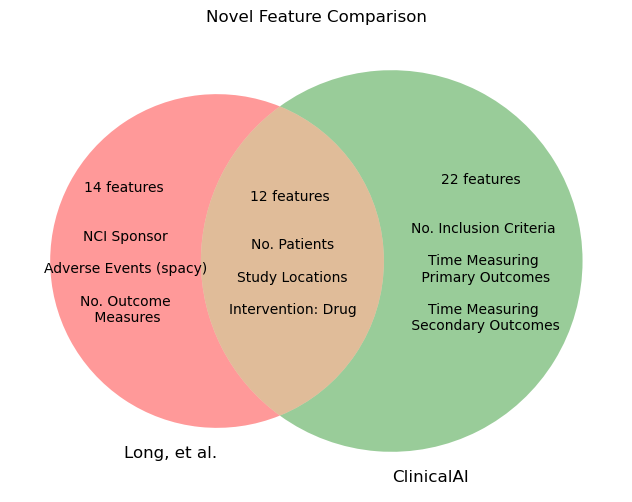

In [19]:
# venn diagram of feature comparison

# Define your two lists of strings
list1 = features_dict['long']['lymphoma']
list2 = features_dict['clinicalai']['lymphoma phase1']

# Convert lists to sets and get unique and common items
set1 = set(list1)
set2 = set(list2)
unique_to_list1 = set1 - set2
unique_to_list2 = set2 - set1
common_to_both = set1 & set2

# Create a dictionary mapping the original list elements to the desired display text
display_dict = {
    'nci_sponsor': 'NCI Sponsor\n',
    'spacy_aes_outcome': 'Adverse Events (spacy)\n',
    'num_oms': 'No. Outcome\n Measures\n',
    'num_inclusion': 'No. Inclusion Criteria\n',
    'secondary_max_days': 'Time Measuring\n Secondary Outcomes\n',
    'enroll_count': 'No. Patients\n',
    'num_locations': 'Study Locations\n',
    'drug_intervention': 'Intervention: Drug\n',
    'primary_max_days': "Time Measuring\n Primary Outcomes\n"
    # Add more mappings as needed
}

selected_unique_to_list1 = ['nci_sponsor', 'spacy_aes_outcome', 'num_oms']  # Example: manually select features
selected_unique_to_list2 = ['num_inclusion', 'primary_max_days', 'secondary_max_days']  # Example: manually select features
selected_common_to_both = ['enroll_count', 'num_locations', 'drug_intervention']

# Function to format the label with selected items and their mapped text
def format_venn_label(items, full_items):
    count = len(full_items)
    # Replace each item with its corresponding display text from the dictionary
    mapped_items = [display_dict.get(item, item) for item in items]  # Use the item if not found in dict
    first_few = "\n".join(mapped_items)  # Join the mapped items
    return f"{count} features \n\n\n{first_few}"

# Create the Venn diagram
plt.figure(figsize=(8, 6))
venn = venn2([set1, set2], set_labels=('Long, et al.', 'ClinicalAI'))

# Update each section of the Venn with the number of items and the selected items with custom text
venn.get_label_by_id('10').set_text(format_venn_label(selected_unique_to_list1, unique_to_list1))  # Unique to List 1
venn.get_label_by_id('01').set_text(format_venn_label(selected_unique_to_list2, unique_to_list2))  # Unique to List 2
venn.get_label_by_id('11').set_text(format_venn_label(selected_common_to_both, common_to_both))   # Common to both

# Display the plot
plt.title("Novel Feature Comparison")
plt.savefig(os.path.join("../figures", "0_paperfig_feature_comparison.png"))
plt.show()
